In [235]:
from src.datasetSimulation.TFFamilyClass import TfFamily
from src.datasetSimulation.simulate_data import SimulatedData
from src.utils.preProcessing import *
from src.modelTraining.maTransformer import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.signal import fftconvolve
from torch.nn.utils.rnn import pad_sequence
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
import sys
from tensorboardX import SummaryWriter

from copy import deepcopy

In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'tensorboard'

In [193]:
tf_object = TfFamily("data/raw_data/PWM.txt", "data/raw_data/prot_seq.txt")

In [194]:
data = SimulatedData(tf_object, n=1)

/Users/mgrapotte/LabWork/LearnTF/src/datasetSimulation/TFFamilyClass.py:71: RuntimeWarning: divide by zero encountered in log2
  m = np.log2(ppm.T/bg)


In [195]:
data.dummy_data

,id,prot_seq,ppm,dna_seq,label
0,prot_00seq_0,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
1,prot_00seq_1,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
2,prot_00seq_2,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
3,prot_00seq_3,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
4,prot_00seq_4,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
...,...,...,...,...,...
395,prot_11seq_95,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
396,prot_11seq_96,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
397,prot_11seq_97,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
398,prot_11seq_98,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1


In [196]:
prot_seq = data.dummy_data.prot_seq.iloc[0]
dna_seq = data.dummy_data.dna_seq.iloc[0]

In [197]:
prot_encoded = encode_protein(prot_seq)

In [198]:
dna_encoded = encode_dna(dna_seq)

In [199]:
prot_tensor = torch.from_numpy(prot_encoded).reshape(1,1,prot_encoded.shape[0], prot_encoded.shape[1]).float()

In [200]:
dna_tensor = torch.from_numpy(dna_encoded).reshape(1,1,dna_encoded.shape[0], dna_encoded.shape[1]).float()

In [201]:
model = maTransformerBlock(filter_dna_size=5, filter_protein_size=5, nb_heads=1)

In [202]:
stacked_prot_tensor = torch.stack([prot_tensor, prot_tensor]).reshape(2,1,21,57)
stacked_dna_tensor = torch.stack([dna_tensor, dna_tensor]).reshape(2,1,4,100)

In [203]:
stacked_prot_tensor.shape

torch.Size([2, 1, 21, 57])

In [206]:
model(stacked_dna_tensor, stacked_prot_tensor).shape

torch.Size([2, 1, 1])

In [16]:
from torch.nn.functional import relu

In [263]:
F.relu(dna_tensor)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### defining the data loader

In [33]:
from torch.utils.data import Dataset

In [34]:
data.dummy_data.columns

Index(['id', 'prot_seq', 'ppm', 'dna_seq', 'label'], dtype='object')

In [35]:
data.dummy_data

,id,prot_seq,ppm,dna_seq,label
0,prot_00seq_0,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
1,prot_00seq_1,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
2,prot_00seq_2,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
3,prot_00seq_3,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
4,prot_00seq_4,RGPRTTIKAKQLETLKXXXXXAAFAATPKPTRHIREQLAQETGLNM...,"[[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0....",TTTTTTTTTTTTTTTTTTTTTTTTTAAAAATTTTTTTTTTTTTTTT...,1
...,...,...,...,...,...
395,prot_11seq_95,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
396,prot_11seq_96,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
397,prot_11seq_97,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1
398,prot_11seq_98,RGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIYY...,"[[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1....",TTTTTTTTTTTTTTTTTTTTTTTTTCCCCCTTTTTTTTTTTTTTTT...,1


In [207]:
class generalData(Dataset):
    def __init__(self, data):
        """
        data is the pandas dataframe from the xxx class
        """
        
        self.dna = np.stack([encode_dna(d) for d in data["dna_seq"]])
        self.dna = torch.from_numpy(self.dna).reshape(self.dna.shape[0],1,self.dna.shape[1],self.dna.shape[2]).float()
        self.prot = np.stack([encode_protein(p) for p in data["prot_seq"]])
        self.prot = torch.from_numpy(self.prot).reshape(self.prot.shape[0],1,self.prot.shape[1],self.prot.shape[2]).float()
        #self.label = torch.from_numpy(OneHotEncoder().fit_transform(data["label"].values.reshape(-1,1)).toarray()).float()
        self.label = data["label"].values
    def __len__(self):
        return len(self.label)
        
    def __getitem__(self, idx):
        #return self.dna[idx,:,:,:], self.prot[idx,:,:,:], self.label[idx,:]
        return self.dna[idx,:,:,:], self.prot[idx,:,:,:], self.label[idx]

In [208]:
from torch.utils.data import DataLoader

In [209]:
test = generalData(data.dummy_data)

In [210]:
batch_size = 20

In [211]:
trainloader = DataLoader(generalData(data.dummy_data), batch_size=batch_size, shuffle=True)

In [213]:
dna, prot, labels = next(iter(trainloader))

In [214]:
dna.shape

torch.Size([20, 1, 4, 100])

In [286]:
model = maTransformerBlock(filter_dna_size=5, filter_protein_size=5, nb_heads=1)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

AAAAA_tensor = torch.from_numpy(np.array([[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1]]).T).reshape(model.conv_dna.weight.data.shape)
XXXXX_block = [-1 for _ in range(20)] + [1]
XXXXX_tensor = torch.from_numpy(np.array([XXXXX_block,XXXXX_block,XXXXX_block,XXXXX_block,XXXXX_block]).T).reshape(model.conv_prot.weight.data.shape)
model.conv_dna.weight = torch.nn.Parameter(AAAAA_tensor.float())
model.conv_prot.weight = torch.nn.Parameter(XXXXX_tensor.float())
first_weights = deepcopy(model.linear.weight.data.squeeze().detach().numpy())

In [296]:
test_outputs = []
model.train()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        dna, prot, labels = train

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(dna, prot).squeeze()
        test_outputs.append(outputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        #print(model.linear.weight.grad)
        print(model.conv_dna.weight.grad)
        #print statistics
        #running_loss += loss.item()
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')

print('Finished Training')

tensor([[[[ 0.9703,  1.3914,  1.3512,  1.1634,  0.7454],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.3810, -0.0402,  0.0000,  0.1879,  0.6059]]]])
tensor([[[[ 0.9760,  1.4046,  1.3806,  1.1910,  0.7571],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.4046, -0.0240,  0.0000,  0.1896,  0.6235]]]])
tensor([[[[ 0.9769,  1.4089,  1.3774,  1.1878,  0.7468],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.4005, -0.0315,  0.0000,  0.1896,  0.6306]]]])
tensor([[[[ 0.9674,  1.3883,  1.3474,  1.1677,  0.7510],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.3799, -0.0409,  0.0000,  0.1796,  0.5964]]]])
tensor([[[[ 0.9629,  1.3782,  1.3464,  1.1721,  0.7668],
          [ 0.0000,

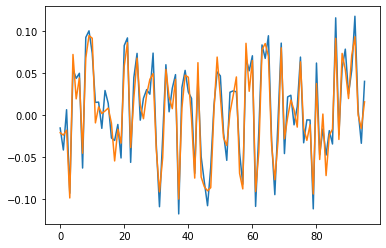

In [295]:
plt.plot(model.linear.weight.data.squeeze().detach().numpy())
plt.plot(first_weights)

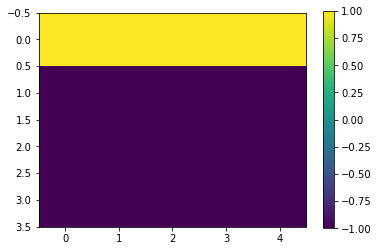

In [297]:
plt.imshow(model.conv_dna.weight.data.squeeze().detach().numpy())
plt.colorbar()

In [299]:
model.conv_dna.weight

Parameter containing:
tensor([[[[ 1.,  1.,  1.,  1.,  1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1.]]]], requires_grad=True)

In [283]:
model.parameters()

<generator object Module.parameters at 0x7f883ad67dd0>

In [307]:
dna = test.__getitem__(2)[0]
prot = test.__getitem__(2)[1]
label = test.__getitem__(2)[2]

dna_unmatch = test.__getitem__(201)[0]
prot_unmach = test.__getitem__(201)[1]
label_unmatch = test.__getitem__(201)[2]

In [130]:
prot.shape

torch.Size([1, 21, 57])

In [131]:
model(dna.reshape(1,1,4,100), prot.reshape(1,1,21,57), verbose=True)

dna_conv: tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 1., 3., 5., 3., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]],
       grad_fn=<ReluBackward0>)
prot_conv: tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 5.,
           3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.]]]], grad_fn=<ReluBackward0>)
output attention: tensor([[[0.1250, 0.1562, 0.1250],
         [0.1250, 0.1562, 0.1250],
         [0.1250, 0.1562, 0.1250],
         [0.1250, 0.1562, 0.1250],
         [0.4797, 0.7550, 0.5006],
         [3.000

tensor([[[ 0.5341, -0.3837]]], grad_fn=<AddBackward0>)

In [132]:
model.linear.weight.data

tensor([[-0.0765, -0.0941, -0.0436, -0.0395, -0.0703,  0.0490,  0.0625,  0.0844,
         -0.0657, -0.0598,  0.0345,  0.0399,  0.0602, -0.0425, -0.0168,  0.0121,
          0.0877,  0.0138, -0.0684, -0.0613, -0.0352,  0.0725,  0.0823,  0.0481,
          0.0227,  0.0595,  0.0400, -0.0878, -0.0089,  0.0142, -0.0302, -0.0570,
          0.0207,  0.0206, -0.0416,  0.0427,  0.1018,  0.0294,  0.0741,  0.0630,
          0.0829, -0.0717,  0.0134,  0.0588, -0.0479,  0.0927,  0.0636,  0.0732,
         -0.0801, -0.1001,  0.0834, -0.0457,  0.0316, -0.0218,  0.0023, -0.0709,
          0.0098,  0.0339, -0.0987,  0.0300, -0.0624,  0.0803, -0.0787,  0.0531,
         -0.0605,  0.0191,  0.0733, -0.0926, -0.0191, -0.0244, -0.0829, -0.0096,
          0.0773,  0.0459,  0.0092, -0.1005,  0.0046, -0.0752, -0.0676, -0.0375,
          0.0871,  0.0642, -0.0013,  0.0572,  0.0107,  0.0138,  0.0228,  0.0747,
         -0.0063, -0.0966,  0.0418,  0.0193,  0.0526, -0.0566,  0.0287,  0.0136],
        [ 0.0353, -0.0564, 

### Creating a new model architecture and setting the weights

In [301]:
model = maTransformerBlock(filter_dna_size=5, filter_protein_size=5, nb_heads=1)

In [302]:
AAAAA_tensor = torch.from_numpy(np.array([[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1],[1,-1,-1,-1]]).T).reshape(model.conv_dna.weight.data.shape)
XXXXX_block = [-1 for _ in range(20)] + [1]
XXXXX_tensor = torch.from_numpy(np.array([XXXXX_block,XXXXX_block,XXXXX_block,XXXXX_block,XXXXX_block]).T).reshape(model.conv_prot.weight.data.shape)

In [303]:
model.conv_dna.weight = torch.nn.Parameter(AAAAA_tensor.float())
model.conv_prot.weight = torch.nn.Parameter(XXXXX_tensor.float())

In [138]:
XXXXX_tensor

tensor([[[[-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1],
          [ 1,  1,  1,  1,  1]]]])

In [139]:
p_test = prot.reshape(1,prot.shape[0],prot.shape[1],prot.shape[2])
d_test = dna.reshape(1,dna.shape[0],dna.shape[1],dna.shape[2])

In [140]:
model.conv_prot(p_test)

tensor([[[[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -3., -1.,
            1.,  3.,  5.,  3.,  1., -1., -3., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [141]:
model.conv_dna(d_test)

tensor([[[[-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -3., -1.,  1.,  3.,  5.,  3.,  1.,
           -1., -3., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
           -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [142]:
scaled_dot_product_attention()

TypeError: scaled_dot_product_attention() missing 3 required positional arguments: 'q', 'k', and 'v'

In [304]:
def model_rebuilding(dna, prot, model=model, batch_size=1):
    p_test = prot.reshape(1,prot.shape[0],prot.shape[1],prot.shape[2])
    d_test = dna.reshape(1,dna.shape[0],dna.shape[1],dna.shape[2])
    prot_conv = model.conv_prot(p_test)
    dna_conv = model.conv_dna(d_test)
    
    prot_conv = F.relu(prot_conv)
    dna_conv = F.relu(dna_conv)

    list_dna    = list(dna_conv.reshape(batch_size, dna_conv.shape[-1]))
    list_prot   = list(prot_conv.reshape(batch_size, prot_conv.shape[-1]))
    padded      = pad_sequence(list_dna+list_prot, batch_first=True, padding_value=0)
    dna_tensor  = padded[:batch_size,:]
    prot_tensor = padded[batch_size:,:]
    
    stacked_d   = torch.stack(torch.chunk(dna_tensor, dna_tensor.shape[1]//model.chunk_size, dim=1))
    stacked_p   = torch.stack(torch.chunk(prot_tensor, prot_tensor.shape[1]//model.chunk_size, dim=1))
    s_d_reshape = stacked_d.reshape(stacked_d.shape[1], stacked_d.shape[0], stacked_d.shape[2])
    s_p_reshape = stacked_p.reshape(stacked_p.shape[1], stacked_p.shape[0], stacked_p.shape[2])
    
    
    
    output, attention = scaled_dot_product_attention(s_p_reshape, s_d_reshape, s_d_reshape, None)
    out_reshaped= output.reshape(batch_size, 1, output.shape[1]*output.shape[2])
    
    out_max_pool = nn.MaxPool1d(kernel_size=model.chunk_size, stride=model.chunk_size)(out_reshaped).sort(dim=2, descending=True)[0]
    
    return dna_conv, out_reshaped, attention

In [308]:
model.chunk_size=3
dna_conv, output, attention = model_rebuilding(dna, prot)

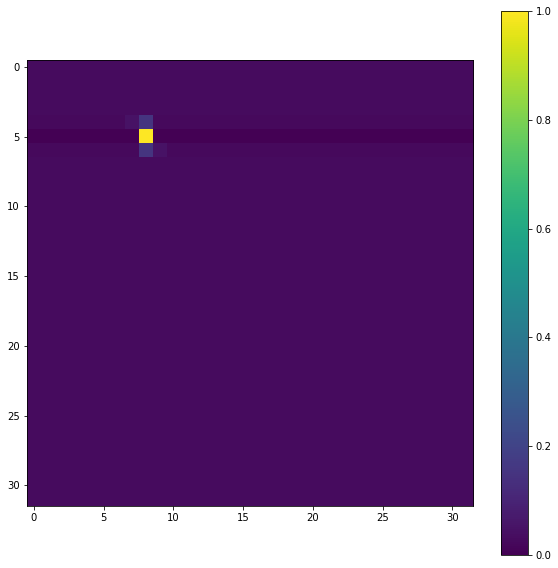

In [309]:
plt.figure(figsize=(10,10))
plt.imshow(attention.squeeze().detach().numpy())
plt.colorbar()

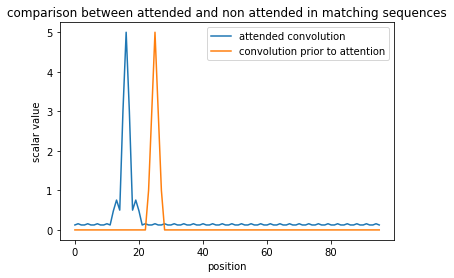

In [310]:
plt.plot(output.squeeze().detach().numpy(), label="attended convolution")
plt.plot(dna_conv.squeeze().detach().numpy(), label="convolution prior to attention")
plt.xlabel("position")
plt.ylabel("scalar value")
plt.title("comparison between attended and non attended in matching sequences")
plt.legend()

In [311]:
model.chunk_size=3
dna_conv, output, attention = model_rebuilding(dna_unmatch, prot_unmach)

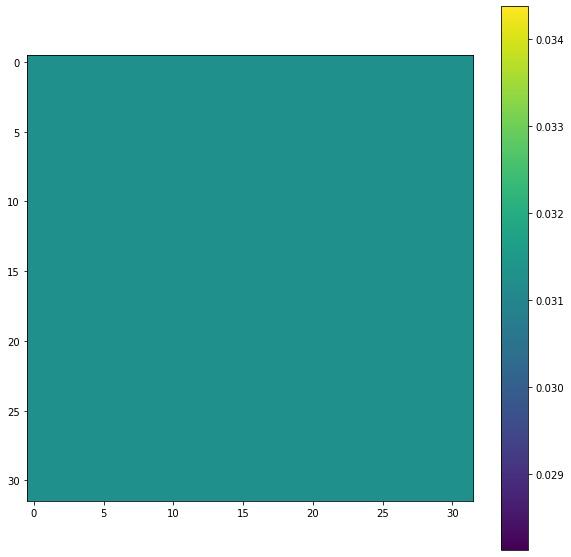

In [312]:
plt.figure(figsize=(10,10))
plt.imshow(attention.squeeze().detach().numpy())
plt.colorbar()

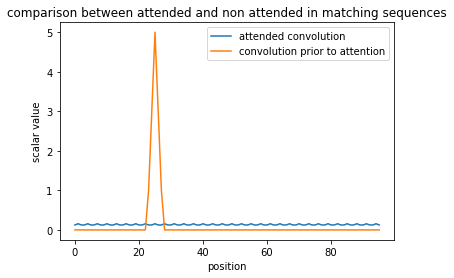

In [313]:
plt.plot(output.squeeze().detach().numpy(), label="attended convolution")
plt.plot(dna_conv.squeeze().detach().numpy(), label="convolution prior to attention")
plt.xlabel("position")
plt.ylabel("scalar value")
plt.title("comparison between attended and non attended in matching sequences")
plt.legend()

In [162]:
output.shape

torch.Size([1, 1, 32])